# Demo: instrument-level processing

This notebook walks through the instrument-level processing in the oceanarray code.


In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import numpy as np
from oceanarray import readers, rodb, instrument, plotters, tools, writers, convertOS
import pandas as pd


## Stage 0 & 1:  Already taken place
 
Assume the output is now `data/wb1_12_2015_6123.raw`.


In [2]:
data_dir = Path(".." ,"data")
input_file = 'wb1_12_2015_6123.raw'
ds = rodb.rodbload(data_dir / input_file)

ds

<xarray.Dataset> Size: 837kB
Dimensions:         (TIME: 11622)
Coordinates:
    N_MEASUREMENTS  (TIME) int64 93kB 0 1 2 3 4 ... 11618 11619 11620 11621
  * TIME            (TIME) datetime64[s] 93kB 2015-11-30T11:00:00 ... 2017-03...
Data variables:
    YY              (TIME) float64 93kB 2.015e+03 2.015e+03 ... 2.017e+03
    MM              (TIME) float64 93kB 11.0 11.0 11.0 11.0 ... 3.0 3.0 3.0 3.0
    DD              (TIME) float64 93kB 30.0 30.0 30.0 30.0 ... 28.0 28.0 28.0
    HH              (TIME) float64 93kB 11.0 12.0 13.0 14.0 ... 14.0 15.0 16.0
    T               (TIME) float64 93kB 21.43 21.93 22.17 ... 8.278 22.91 21.99
    C               (TIME) float64 93kB 0.0113 0.0114 0.0114 ... 53.31 0.1953
    P               (TIME) float64 93kB -0.7 -0.7 -0.7 -0.8 ... 802.0 114.7 -0.4
    InstrDepth      float64 8B 800.0
    Latitude        float64 8B 26.5
    Longitude       float64 8B -76.81
Attributes:
    mooring:        wb1_12_2015
    serial_number:  6123
    water_depth:    1401
    source_file:    ../data/wb1_12_2015_6123.raw
    columns:        ['YY', 'MM', 'DD', 'HH', 'T', 'C', 'P']

## Stage 2: Trim to deployment period 

Show the *.raw file, and then trim (iteratively) to the deployment period, using plotting

Deployment start: 2015-11-30T11:00:00
Deployment end: 2017-03-28T16:00:00


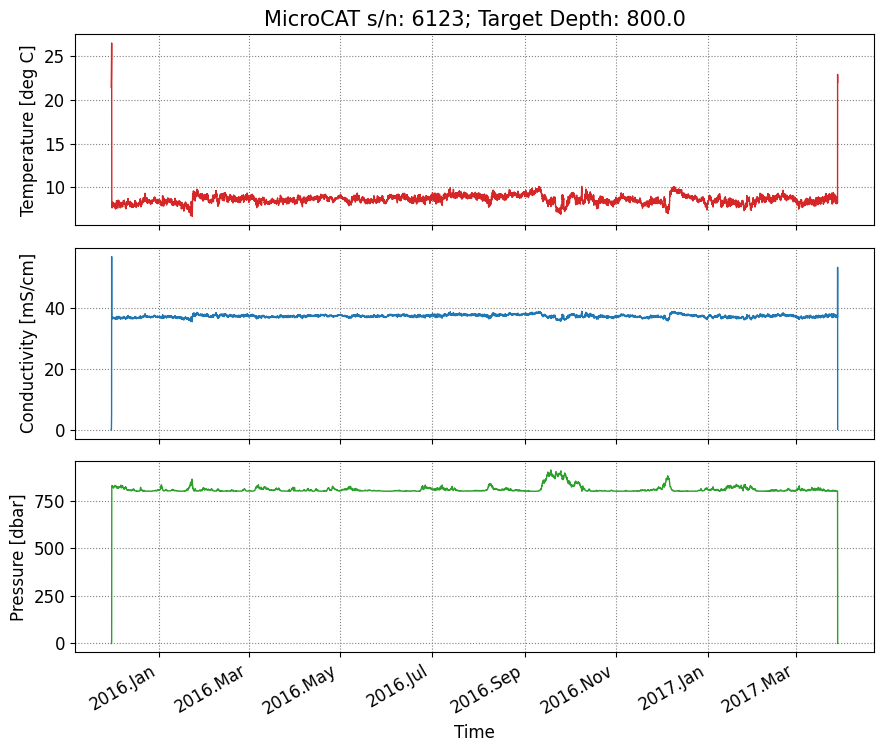

In [3]:

ds2, dstart, dend = instrument.stage2_trim(ds)

print("Deployment start:", dstart)
print("Deployment end:", dend)

fig = plotters.plot_microcat(ds2)



Suggested deployment start: 2015-11-30T19:00:00
Suggested deployment end: 2017-03-28T14:00:00


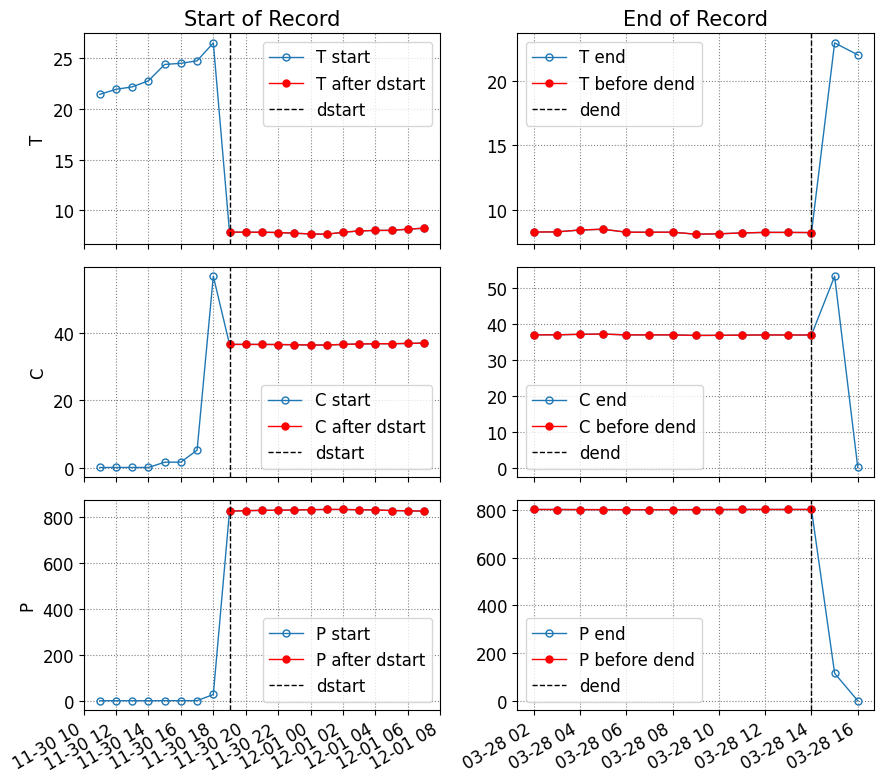

In [4]:
dstart, dend = instrument.trim_suggestion(ds)
fig, ax = plotters.plot_trim_windows(ds, dstart, dend)


Deployment start: 2015-11-30T19:00:00
Deployment end: 2017-03-28T14:00:00


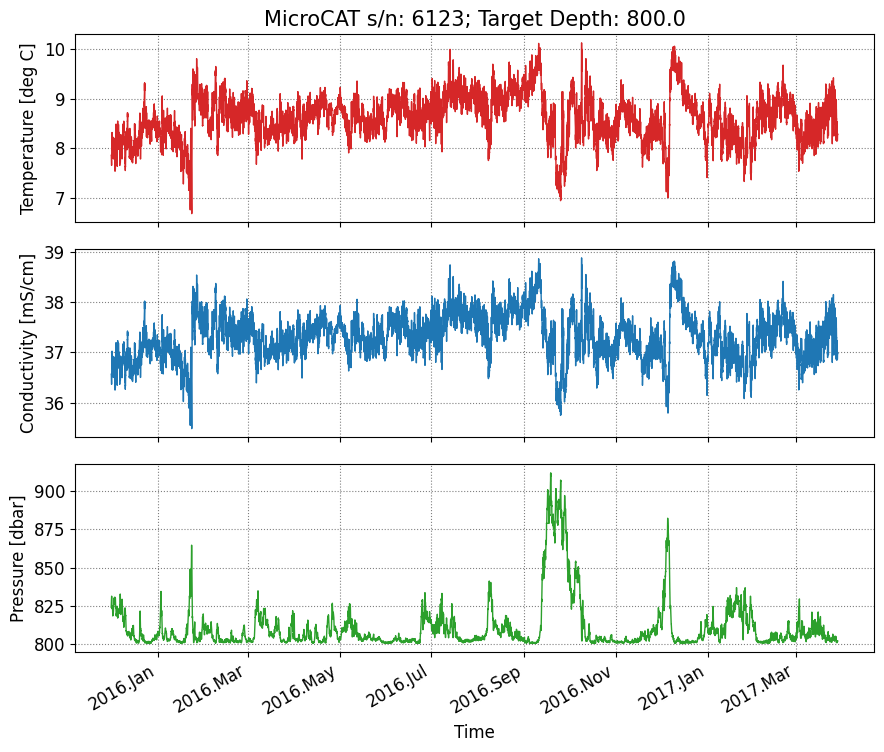

In [5]:
dstart = np.datetime64('2015-11-30T19:00:00')
dend = np.datetime64('2017-03-28T14:00:00')

ds2, dstart, dend = instrument.stage2_trim(ds, deployment_start=dstart, deployment_end=dend)

print("Deployment start:", dstart)
print("Deployment end:", dend)

fig = plotters.plot_microcat(ds2)

## Stage 3: Apply calibrations

In [6]:
ds_cal = instrument.apply_microcat_calibration_from_txt(data_dir / 'wb1_12_2015_005.microcat.txt', data_dir / 'wb1_12_2015_6123.use')
ds_cal


<xarray.Dataset> Size: 836kB
Dimensions:         (TIME: 11612)
Coordinates:
    N_MEASUREMENTS  (TIME) int64 93kB 0 1 2 3 4 ... 11608 11609 11610 11611
  * TIME            (TIME) datetime64[s] 93kB 2015-11-30T19:00:00 ... 2017-03...
Data variables:
    YY              (TIME) float64 93kB 2.015e+03 2.015e+03 ... 2.017e+03
    MM              (TIME) float64 93kB 11.0 11.0 11.0 11.0 ... 3.0 3.0 3.0 3.0
    DD              (TIME) float64 93kB 30.0 30.0 30.0 30.0 ... 28.0 28.0 28.0
    HH              (TIME) float64 93kB 19.0 20.0 21.0 22.0 ... 12.0 13.0 14.0
    T               (TIME) float64 93kB 7.859 7.854 7.846 ... 8.293 8.291 8.278
    C               (TIME) float64 93kB 36.59 36.58 36.57 ... 37.02 37.01 37.0
    P               (TIME) float64 93kB 822.0 824.1 825.3 ... 800.0 799.9 800.0
    InstrDepth      float64 8B 800.0
    Latitude        float64 8B 26.5
    Longitude       float64 8B -76.81
Attributes:
    mooring:          wb1_12_2015
    serial_number:    6123
    water_depth:      1401
    start_time:       2015/11/30T19:00
    end_time:         2017/03/28T14:00
    source_file:      ../data/wb1_12_2015_6123.use
    columns:          ['YY', 'MM', 'DD', 'HH', 'T', 'C', 'P']
    calibration_log:  ../data/wb1_12_2015_005.microcat.txt
    comment:          Calibration offsets applied from microcat log file.

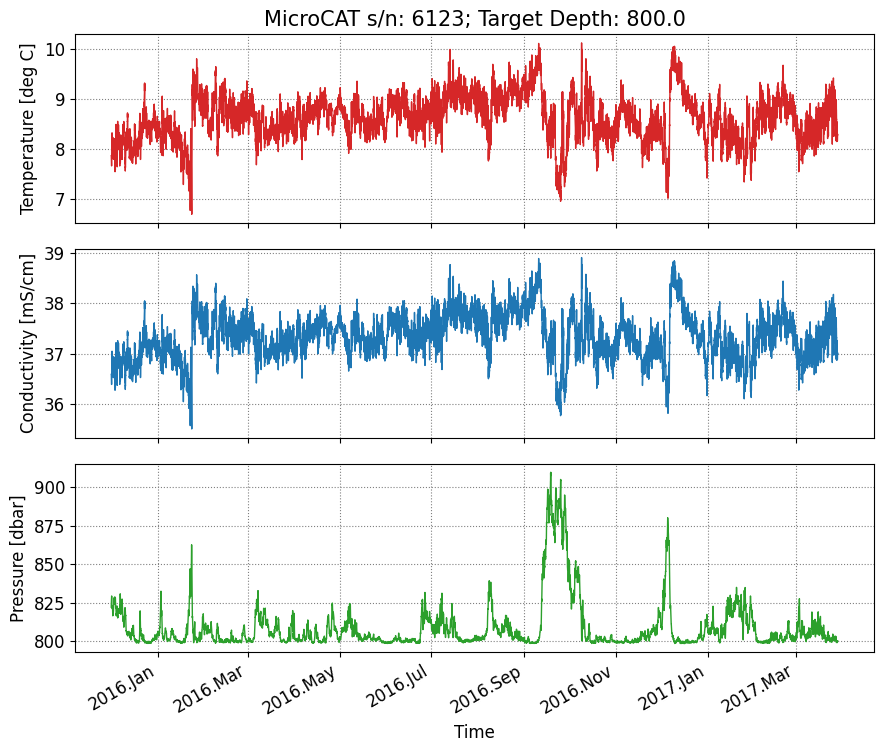

In [7]:
fig = plotters.plot_microcat(ds_cal)

Text(0.5, 0.98, 'difference between *.use and *.microcat')

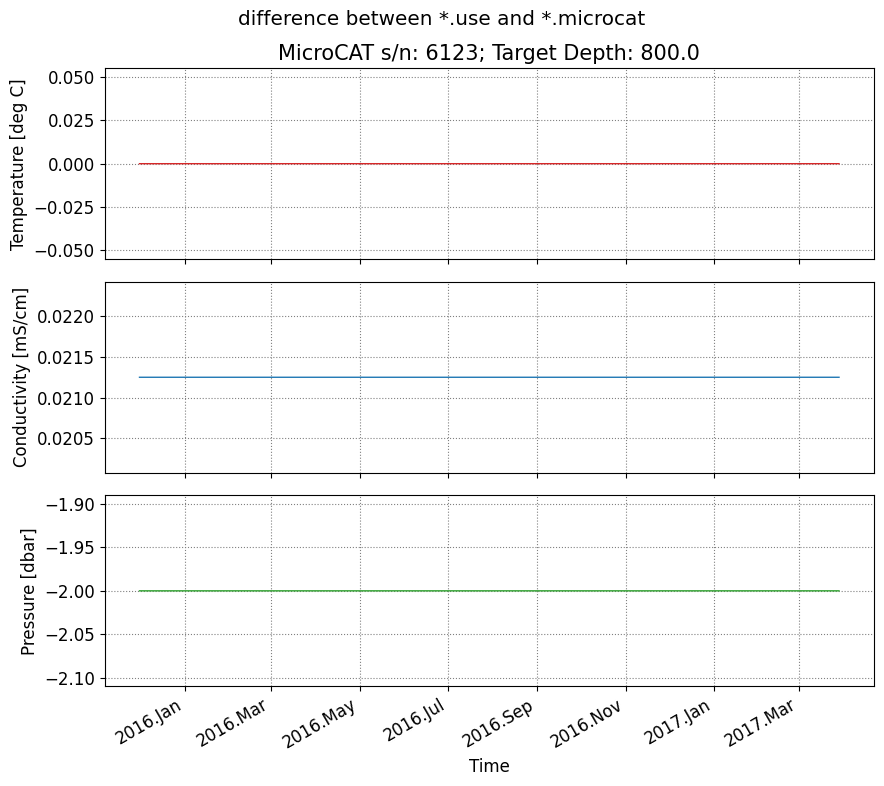

In [8]:
ds_diff = tools.calc_ds_difference(ds_cal, ds2)
fig = plotters.plot_microcat(ds_diff)
fig.suptitle("difference between *.use and *.microcat")

## Stage 4: Convert to OceanSites format


In [9]:

metadata_txt = data_dir / 'wb1_12_2015_6123.use'
config_dir = Path("..") / "oceanarray" / "config"
var_map_yaml = config_dir / "OS1_var_names.yaml"
vocab_yaml = config_dir / "OS1_vocab_attrs.yaml"
sensor_yaml = config_dir / "OS1_sensor_attrs.yaml"
project_yaml = config_dir / "project_RAPID.yaml"
ds_OS = convertOS.convert_rodb_to_oceansites(ds_cal, metadata_txt, var_map_yaml, vocab_yaml, sensor_yaml=sensor_yaml,project_yaml=project_yaml)


In [10]:
ds_OS

<xarray.Dataset> Size: 372kB
Dimensions:          (TIME: 11612, DEPTH: 1, LATITUDE: 1, LONGITUDE: 1)
Coordinates:
  * TIME             (TIME) datetime64[s] 93kB 2015-11-30T19:00:00 ... 2017-0...
  * DEPTH            (DEPTH) float64 8B 800.0
  * LATITUDE         (LATITUDE) float64 8B 26.5
  * LONGITUDE        (LONGITUDE) float64 8B -76.81
Data variables:
    TEMP             (TIME, DEPTH, LATITUDE, LONGITUDE) float64 93kB 7.859 .....
    CNDC             (TIME, DEPTH, LATITUDE, LONGITUDE) float64 93kB 36.59 .....
    PRES             (TIME, DEPTH, LATITUDE, LONGITUDE) float64 93kB 822.0 .....
    InstrDepth       (DEPTH, LATITUDE, LONGITUDE) float64 8B 800.0
    SENSOR_CTD_6123  (DEPTH) float64 8B 800.0
Attributes: (12/57)
    site_code:                         RAPID
    platform_code:                     wb1
    deployment_code:                   12_2015
    data_mode:                         P
    title:                             Time series from wb1_12_2015, instrume...
    theme:                             Transport Moored Arrays
    ...                                ...
    QC_indicator:                      None
    serial_number:                     6123
    water_depth:                       1401
    source_file:                       ../data/wb1_12_2015_6123.use
    columns:                           ['YY', 'MM', 'DD', 'HH', 'T', 'C', 'P']
    calibration_log:                   ../data/wb1_12_2015_005.microcat.txt

In [12]:
filepath = writers.save_OS_instrument(ds_OS, data_dir)
print(filepath)

../data/OS_wb1_12_2015_6123_P.nc
